# Forecasting Supermarket Sales

### Introduction

For this project, I am aiming to predict sales based on historical data using supervised machine learning technique XG regression. This is a supermarket chain with 54 locations across Ecuador. Given the data from 2013 to 2017, the problem is to forecast the sales for 2 weeks in 2017. This is a regression problem, since I will be trying to predict a continuous value. It is important to be able to forecast sales to order accordingly, minimizing wasted products and increasing profits. <br>

All of the datasets came from Kaggle. I will be using the data_train dataset to split into training and testing data using 80/20 split. 

Citations:
Kaggle. N/A. Store Sales - Time Series Forecasting, Version 1. Retrieved Aug 5, 2024 from https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data.

In [45]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

### Exploratory Data Analysis (EDA) and Feature Engineering

In [46]:
#import the data 
data_oil = pd.read_csv('raw_data/oil.csv')
data_holidays = pd.read_csv('raw_data/holidays_events.csv')
data_stores = pd.read_csv('raw_data/stores.csv')
data_train = pd.read_csv('raw_data/train.csv')
data_transactions = pd.read_csv('raw_data/transactions.csv')

#print out general info abput the datasets
names = ['data_oil', 'data_holidays', 'data_stores', 'data_train', 'data_transactions']
for name, data in zip(names, [data_oil, data_holidays, data_stores, data_train, data_transactions]):
    print('shape of', name, data.shape)
    #print('columns in', name , ':', data.columns )
    print ('column types in', name ,':')
    print(data.dtypes)
    missing_values = data_train[data_train.isnull().any(axis=1)]
    if missing_values.empty:
        print('There are no missing values')
    else:
        print(missing_values)
    display(data.head())
    print('\n')
    


shape of data_oil (1218, 2)
column types in data_oil :
date           object
dcoilwtico    float64
dtype: object
There are no missing values


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20




shape of data_holidays (350, 6)
column types in data_holidays :
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
There are no missing values


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False




shape of data_stores (54, 5)
column types in data_stores :
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
There are no missing values


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4




shape of data_train (3000888, 6)
column types in data_train :
id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object
There are no missing values


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0




shape of data_transactions (83488, 3)
column types in data_transactions :
date            object
store_nbr        int64
transactions     int64
dtype: object
There are no missing values


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In addition to the information above, here are the data colunm descriptions: <br>
<br>
for data_oil : <br>
date indicates the date <br>
dcoilwtico indicates the oil price on that date <br>
<br>

for data_holidays <br>
date indicates the date <br>
type indicates whether it a aholiday or an event <br>
locale tracks whether it is a national , regional or local holiday/event <br>
locale_name tracks where the evnt is taking place<br>
description tracks the name of the holidya/event<br>
transferred tracks whether the holday/event was moved from a holiday to the next weekday<br>
<br>

for data_stores<br>
store_nbr tracks the assigned store number<br>
city indicates the city in which that store is located<br>
state indicates the state in which that store is located<br>
type indicates the type of store<br>
cluster indicates the store cluster<br>

	
for data_train<br>
id is the id of the observation<br>
date indicates the date<br>
store_nbr indicates the store number (same as in data_stores)<br>
family indicates the item family <br>
sales tracks the sales for that particular item family on that date at that store<br>
onpromotion indicates how many items are on promotion at that store<br>
<br>
for data_transactions:<br>
date indicates the date<br>
store_nbr indicates the store number (same as in data_stores and data_train)<br>	
transactions indicates the number of transactions on that date at that store.<br>
<br>
Above are the data descriptions, including the number of rows, number of columns, data type of each feature , description of features.

In [47]:

#Create columns for year, month, date, day of week for easier aggregation
for name, data in zip(names, [data_oil, data_holidays, data_stores,  data_train, data_transactions]):
    print()
    print('processing', name, '...')
    if 'date' in data.columns:
        #Convert from object to datetime 
        data.date = pd.to_datetime(data.date)
        data['year'] = data.date.dt.year
        data['month'] = data.date.dt.month
        data['day'] = data.date.dt.day
        data['day_of_week'] = data.date.dt.dayofweek
        data['day_name'] = data.date.dt.strftime('%A')
    
    else:
        print('the date column does not exist in', name)



processing data_oil ...

processing data_holidays ...

processing data_stores ...
the date column does not exist in data_stores

processing data_train ...

processing data_transactions ...


In [48]:
#merge the data

#Clone the df to compare after merging
data_train_original = data_train

#Merge the oil data 
data_train = pd.merge(data_train, data_oil[['date', 'dcoilwtico']], on='date', how='left')

#Merge holidays data
data_holidays.rename(columns={'type': 'holiday_type'}, inplace=True)
data_train = pd.merge(data_train, data_holidays, on = ['date', 'day', 'month', 'year', 'day_of_week', 'day_name'], how = 'left')

#Merge the store data
data_stores.rename(columns={'type': 'store_type'}, inplace=True)
data_train = pd.merge(data_train, data_stores, on='store_nbr', how='left')

#Merge the transactions data
data_train = pd.merge(data_train, data_transactions, on = ['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'], how='left')


In [49]:
print('The number of rows increased from', data_train_original.shape[0], 'to', data_train.shape[0], 'due to local and national holiday overlap.')

The number of rows increased from 3000888 to 3054348 due to local and national holiday overlap.


In [50]:
# How many unique stores are there in the training set?
print('There are', len(data_train['store_nbr'].unique()) , 'unique store IDs in the training dataset.')



There are 54 unique store IDs in the training dataset.


In [51]:
#Is there any difference between stores closer to the eartquake vs further?

print('There are',len(data_stores.state.unique()), 'unique values in the state column.')

# According to worldvision.org these states were affected the most by the earthquake
worst_affected_states= ['Manabi', 'Esmeraldas', 'Sanat Elena', 'Guayas', 'Santo Domingo de los Tsachilas', 'Los Rios']
print('There are ',len(data_stores.city.unique()), 'unique values in the city column')

# Find the cities that are located in these states
worst_affected_cities = data_stores[data_stores['state'].isin(worst_affected_states)]['city'].unique().tolist()

#Find the stores taht are located in these states
worst_affected_stores = data_stores[data_stores['state'].isin(worst_affected_states)]['store_nbr'].unique().tolist()
print('These are the states that were affected by the earthquake the most: ', worst_affected_states)
print('These are the cities that were affected by the earthquake the most: ', worst_affected_cities)
print('These are the ', len(worst_affected_stores), 'stores that were affected by the earthquake the most: ', worst_affected_stores)

There are 16 unique values in the state column.
There are  22 unique values in the city column
These are the states that were affected by the earthquake the most:  ['Manabi', 'Esmeraldas', 'Sanat Elena', 'Guayas', 'Santo Domingo de los Tsachilas', 'Los Rios']
These are the cities that were affected by the earthquake the most:  ['Santo Domingo', 'Guayaquil', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Esmeraldas', 'Manta', 'El Carmen']
These are the  20 stores that were affected by the earthquake the most:  [5, 16, 21, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 43, 51, 52, 53, 54]


### Data Visualization

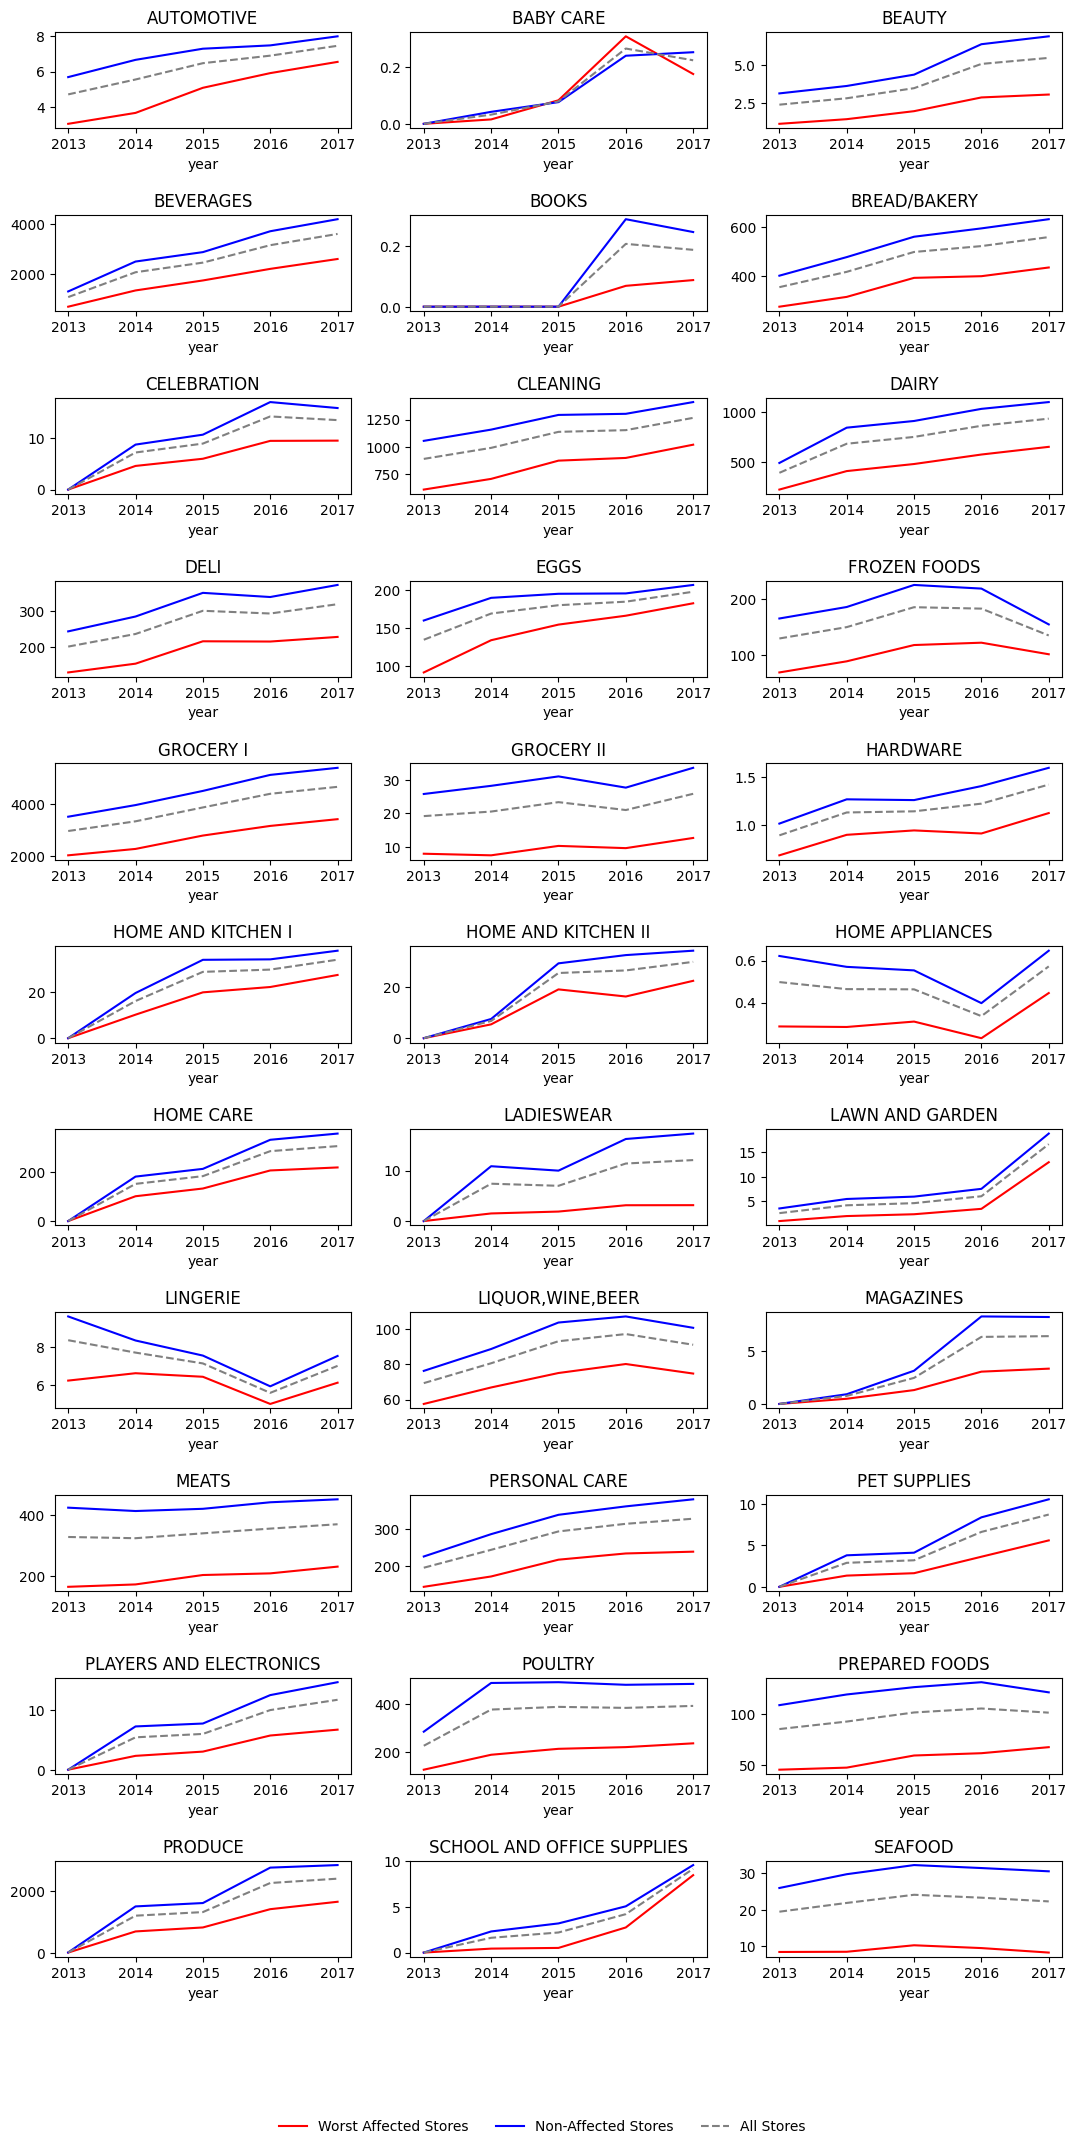

In [52]:
#What are the year-to-year trends in the most affected stores vs others vs the mean?

fig = plt.figure(figsize=(13, 25))
fig.subplots_adjust(hspace=0.9, wspace=0.2)

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, product in enumerate(data_train.family.unique()):
    ax = fig.add_subplot(11, 3, i + 1)
    
    # Plot for worst-affected stores (red color)
    data_train[data_train['store_nbr'].isin(worst_affected_stores)].query('family == @product').groupby(['year']).sales.mean().plot(ax=ax, color='red', label='Worst Affected Stores')
    
    # Plot for non-affected stores (blue color)
    data_train[~data_train['store_nbr'].isin(worst_affected_stores)].query('family == @product').groupby(['year']).sales.mean().plot(ax=ax, color='blue', label='Non-Affected Stores')
    
    # Plot for all stores combined (grey color)
    data_train.query('family == @product').groupby(['year']).sales.mean().plot(ax=ax, color='grey', label='All Stores', linestyle='--')
    
    # Set the title of the subplot
    plt.title(product)
    
    # Collect the handles and labels only once (from the first subplot)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, frameon=False)

plt.savefig('plot1.jpg')

As can be seen from the graph above, the stores located in the areas affected most by the 2016 earthquake (red) have been historically performing worse than the rest (blue). Most of them follow the same sales pattern but on a smaller scale. Most item families have a generally upward growth trend over the years, with the notable exception being lingerie which hit the minimum in 2016 but recovered in 2017 and frozen foods, since the 2017 dataset does not include december, the highest grossing month in frozen food sales, as will be demonstrated shortly.

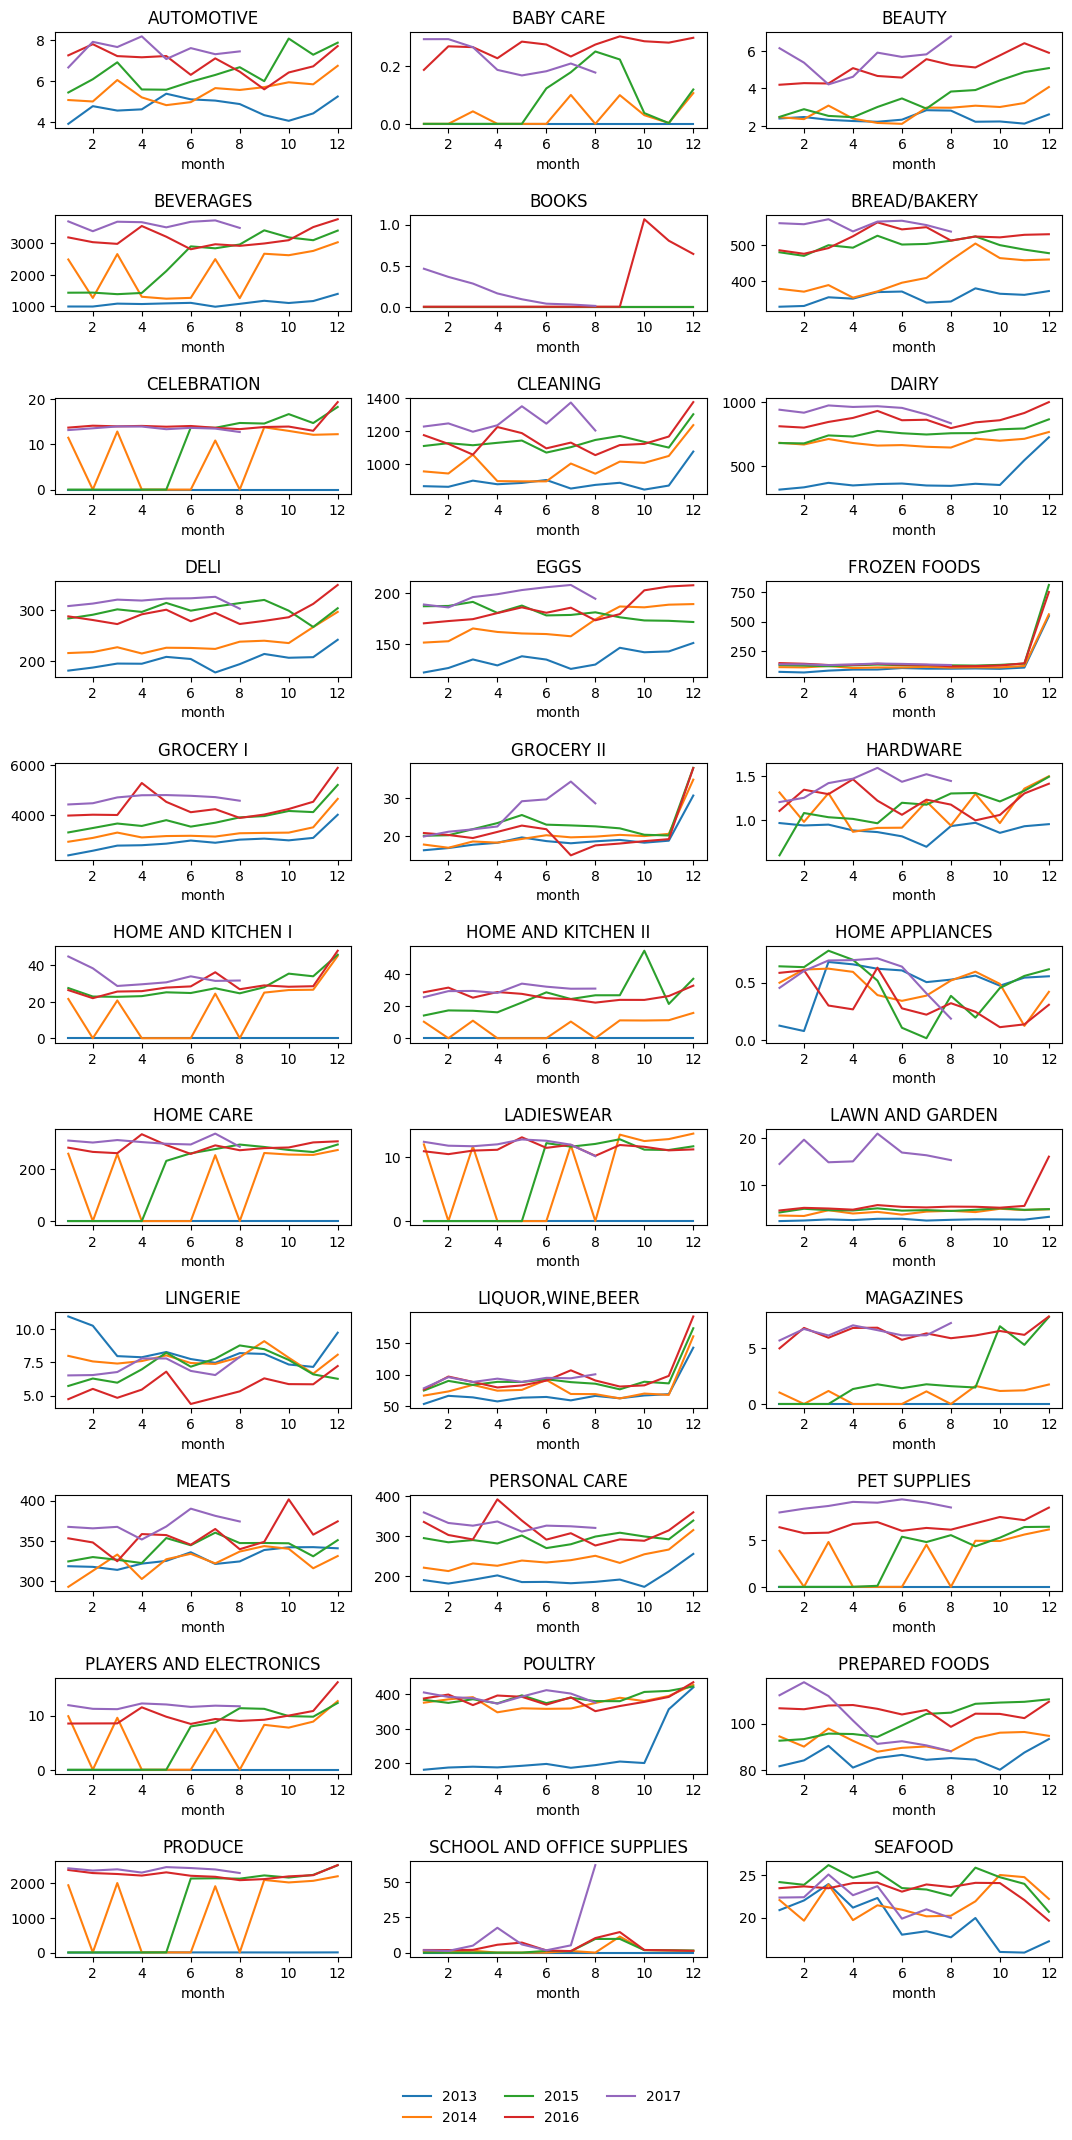

In [53]:
#What are the trends month-by-month each year?
fig = plt.figure(figsize=(13, 25))
fig.subplots_adjust(hspace=0.9, wspace=0.2)

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, product in enumerate(data_train.family.unique()):
    ax = fig.add_subplot(11, 3, i + 1)
    
    select = data_train.query('family==@product')
    for year in [2013,2014,2015,2016,2017]: 
        select.query('year==@year').groupby(['month']).sales.mean().plot(ax=ax,label=year)

    plt.title(product)
    
    # Collect the handles and labels only once (from the first subplot)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=3, frameon=False)

plt.show()


Liquor, wine, beer' , 'Frozen foods', 'Grocery I',  'Grocery II', and 'Home and Kitchen I' seem to spike in december every year. In specific categories the sales are at 0 the whole year. With most of them being in 2013, it is likely that either those stores did not carry those items at the time, or this is a tracking or entry error. Thus, I will remove them from the dataset. <br>
In 2014 the data is spotty, with the months 2, 4, 5, 6, 8 presenting 0 sales in 11 different categories. This is likely an error as well. I will duplicate the dataset before imputing these values. I will replace the missing values with the mean sales in that family for the other months of the year.  <br>
In 2017 there are spikes in 'Lawn and Garden' and 'School and office supplies'. I will analyze whether these values are outliers by examining whether the sales happen in one location or in different ones.<br>



In [54]:
#Remove the years with 0 sales 
#Create a new training df that drops null values

#Identify the categories and years in which the wjole year the sales are 0
zero_sales = data_train.groupby(['family', 'year'])['sales'].sum().reset_index()
#display(zero_sales)
zero_sales = zero_sales.query('sales==0')
display(zero_sales)
print('There are',len(zero_sales), 'categories in which for a whole year the sales were 0. We will drop those observations.')

#Create a boolean mask for groups with zero total sales
zero_sales_mask = data_train.groupby(['family', 'year'])['sales'].transform('sum') == 0

#Filter out the rows where the mask is True
data_train_filtered = data_train[~zero_sales_mask]

#Convert year back to int
data_train_filtered = data_train_filtered.copy()
data_train_filtered['year'] = data_train_filtered['year'].astype(int)

print('To check that they were removed correctly, check the shapes of the original data-train and the new dataframe. Original shape:', data_train.shape, 'New shape:', data_train_filtered.shape,'.', (data_train.shape[0] - data_train_filtered.shape[0]) ,'observations were removed.')


,family,year,sales
5,BABY CARE,2013,0.0
20,BOOKS,2013,0.0
21,BOOKS,2014,0.0
22,BOOKS,2015,0.0
30,CELEBRATION,2013,0.0
75,HOME AND KITCHEN I,2013,0.0
80,HOME AND KITCHEN II,2013,0.0
90,HOME CARE,2013,0.0
95,LADIESWEAR,2013,0.0
115,MAGAZINES,2013,0.0


There are 13 categories in which for a whole year the sales were 0. We will drop those observations.
To check that they were removed correctly, check the shapes of the original data-train and the new dataframe. Original shape: (3054348, 22) New shape: (2795310, 22) . 259038 observations were removed.


In [55]:
#copy the unfiltered dataset to compare the accuracy
data1 = data_train_filtered.copy()

In [56]:
# Replace the sales for 11 categoriwes in months 2, 4, 5, 6, 8 in 2014 with the mean sales
# Filter data for 2014 only
data_2014 = data_train_filtered[data_train_filtered['year'] == 2014]

# Define the affected months and categories
affected_months = [2, 4, 5, 6, 8]
affected_categories = ['BABY CARE', 'BEVERAGES', 'CELEBRATION', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 
                       'HOME CARE', 'LADIESWEAR', 'MAGAZINES', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'PRODUCE']

# Create a mask to identify the affected rows
mask = (data_2014['month'].isin(affected_months)) & (data_2014['family'].isin(affected_categories)) & (data_2014['sales'] == 0)

# Subset the affected data
affected_data = data_2014.loc[mask]

# Calculate the mean sales for each family in unaffected months (excluding 2, 4, 5, 6, 8)
mean_sales_other_months = data_2014[~data_2014['month'].isin(affected_months)] \
    .groupby(['family'])['sales'].mean().reset_index().rename(columns={'sales': 'mean_sales'})

# Merge the mean sales back to the affected data
affected_data_with_means = affected_data.merge(mean_sales_other_months, on='family', how='left')

# Replace the sales values in data_train_filtered with the mean sales from other months
# Ensure the index remains aligned by using the `affected_data.index`
data_train_filtered.loc[affected_data.index, 'sales'] = affected_data_with_means['mean_sales'].values

# Display the affected rows before and after replacement for verification
comparison_df = affected_data_with_means[['family', 'store_nbr', 'month', 'sales', 'mean_sales']].copy()
comparison_df['sales_before'] = 0  # Since sales were 0 in the affected rows
comparison_df['sales_after'] = affected_data_with_means['mean_sales'].values

print(comparison_df[['family', 'store_nbr', 'month', 'sales_before', 'sales_after']])


                        family  store_nbr  month  sales_before  sales_after
0                    BABY CARE          1      2             0     0.054788
1                  CELEBRATION          1      2             0    12.300478
2           HOME AND KITCHEN I          1      2             0    27.234255
3          HOME AND KITCHEN II          1      2             0    11.521164
4                    HOME CARE          1      2             0   260.821813
...                        ...        ...    ...           ...          ...
80445               LADIESWEAR          9      8             0    12.612221
80446                MAGAZINES          9      8             0     1.300905
80447             PET SUPPLIES          9      8             0     4.947773
80448  PLAYERS AND ELECTRONICS          9      8             0     9.258065
80449                  PRODUCE          9      8             0  2032.047027

[80450 rows x 5 columns]


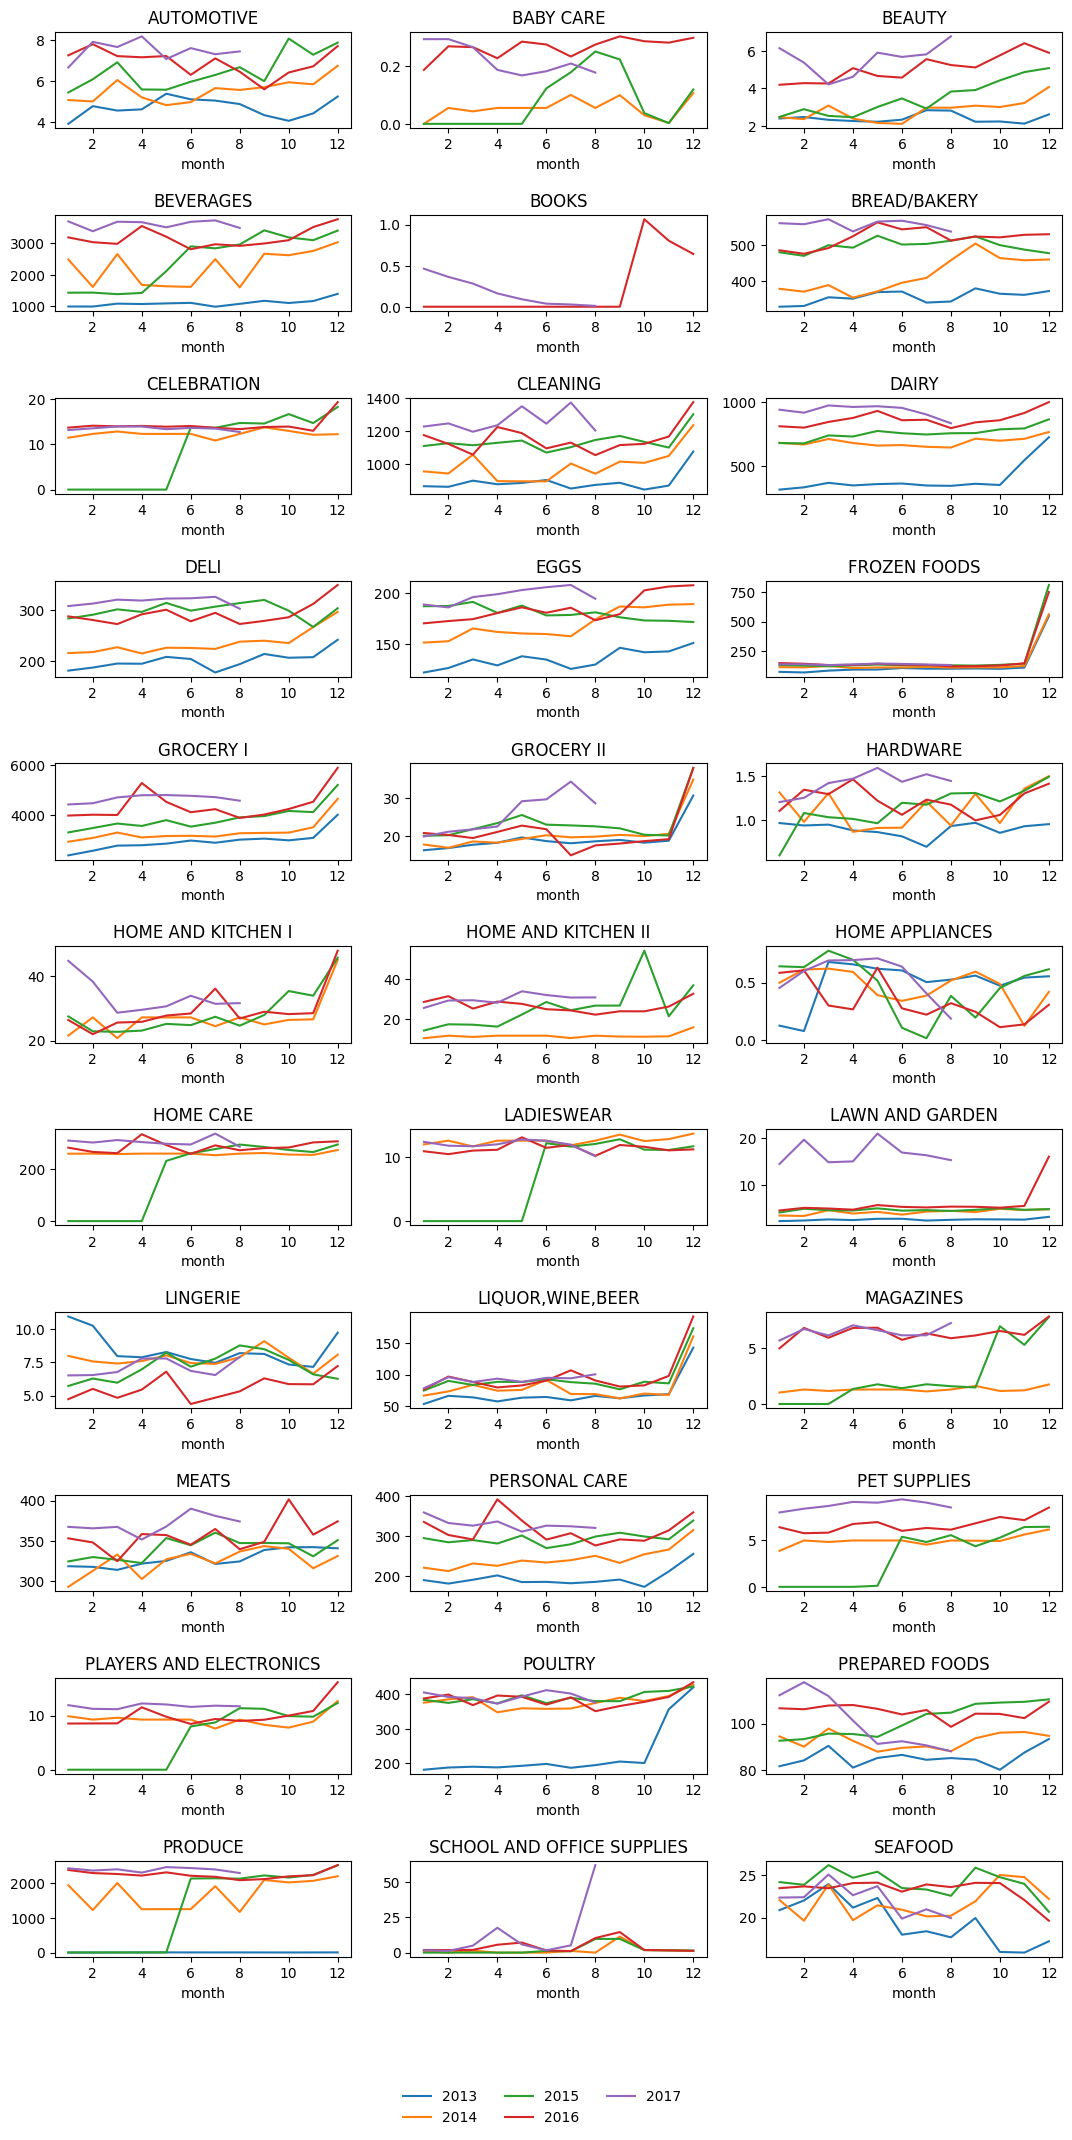

'Liquor, wine, beer' , 'Frozen foods', 'Grocery I',  'Grocery II', and 'Home and Kitchen I' seem to spike in december every year


In [57]:
#Display the month-to-month graphs after removing the zero-sale years

fig = plt.figure(figsize=(13, 25))
fig.subplots_adjust(hspace=0.9, wspace=0.2)

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, product in enumerate(data_train.family.unique()):
    ax = fig.add_subplot(11, 3, i + 1)
    
    select = data_train_filtered.query('family==@product')
    for year in [2013,2014,2015,2016,2017]: 
        select.query('year==@year').groupby(['month']).sales.mean().plot(ax=ax,label=year)

    plt.title(product)
    
    # Collect the handles and labels only once (from the first subplot)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=3, frameon=False)

plt.show()

print("'Liquor, wine, beer' , 'Frozen foods', 'Grocery I',  'Grocery II', and 'Home and Kitchen I' seem to spike in december every year")

After removing the entries for the years with no sales in specific categories, along with imputing the missing information of the sales for 11 categories in months 2, 4, 5, 6, 8 in 2014, the graphs show no apparent irregularities. While the produce in 2013 appears to be flat at 0, it is actually not.

In [58]:
#Notice that the line for produce in 2013 appears flat. Check what is happening
produce_2013 = data_train_filtered.query('family == "PRODUCE" and year == 2013 and sales != 0')
print('There are', produce_2013.shape[0], 'rows with non-zero sales in the Produce family in the year 2013.')

There are 6366 rows with non-zero sales in the Produce family in the year 2013.


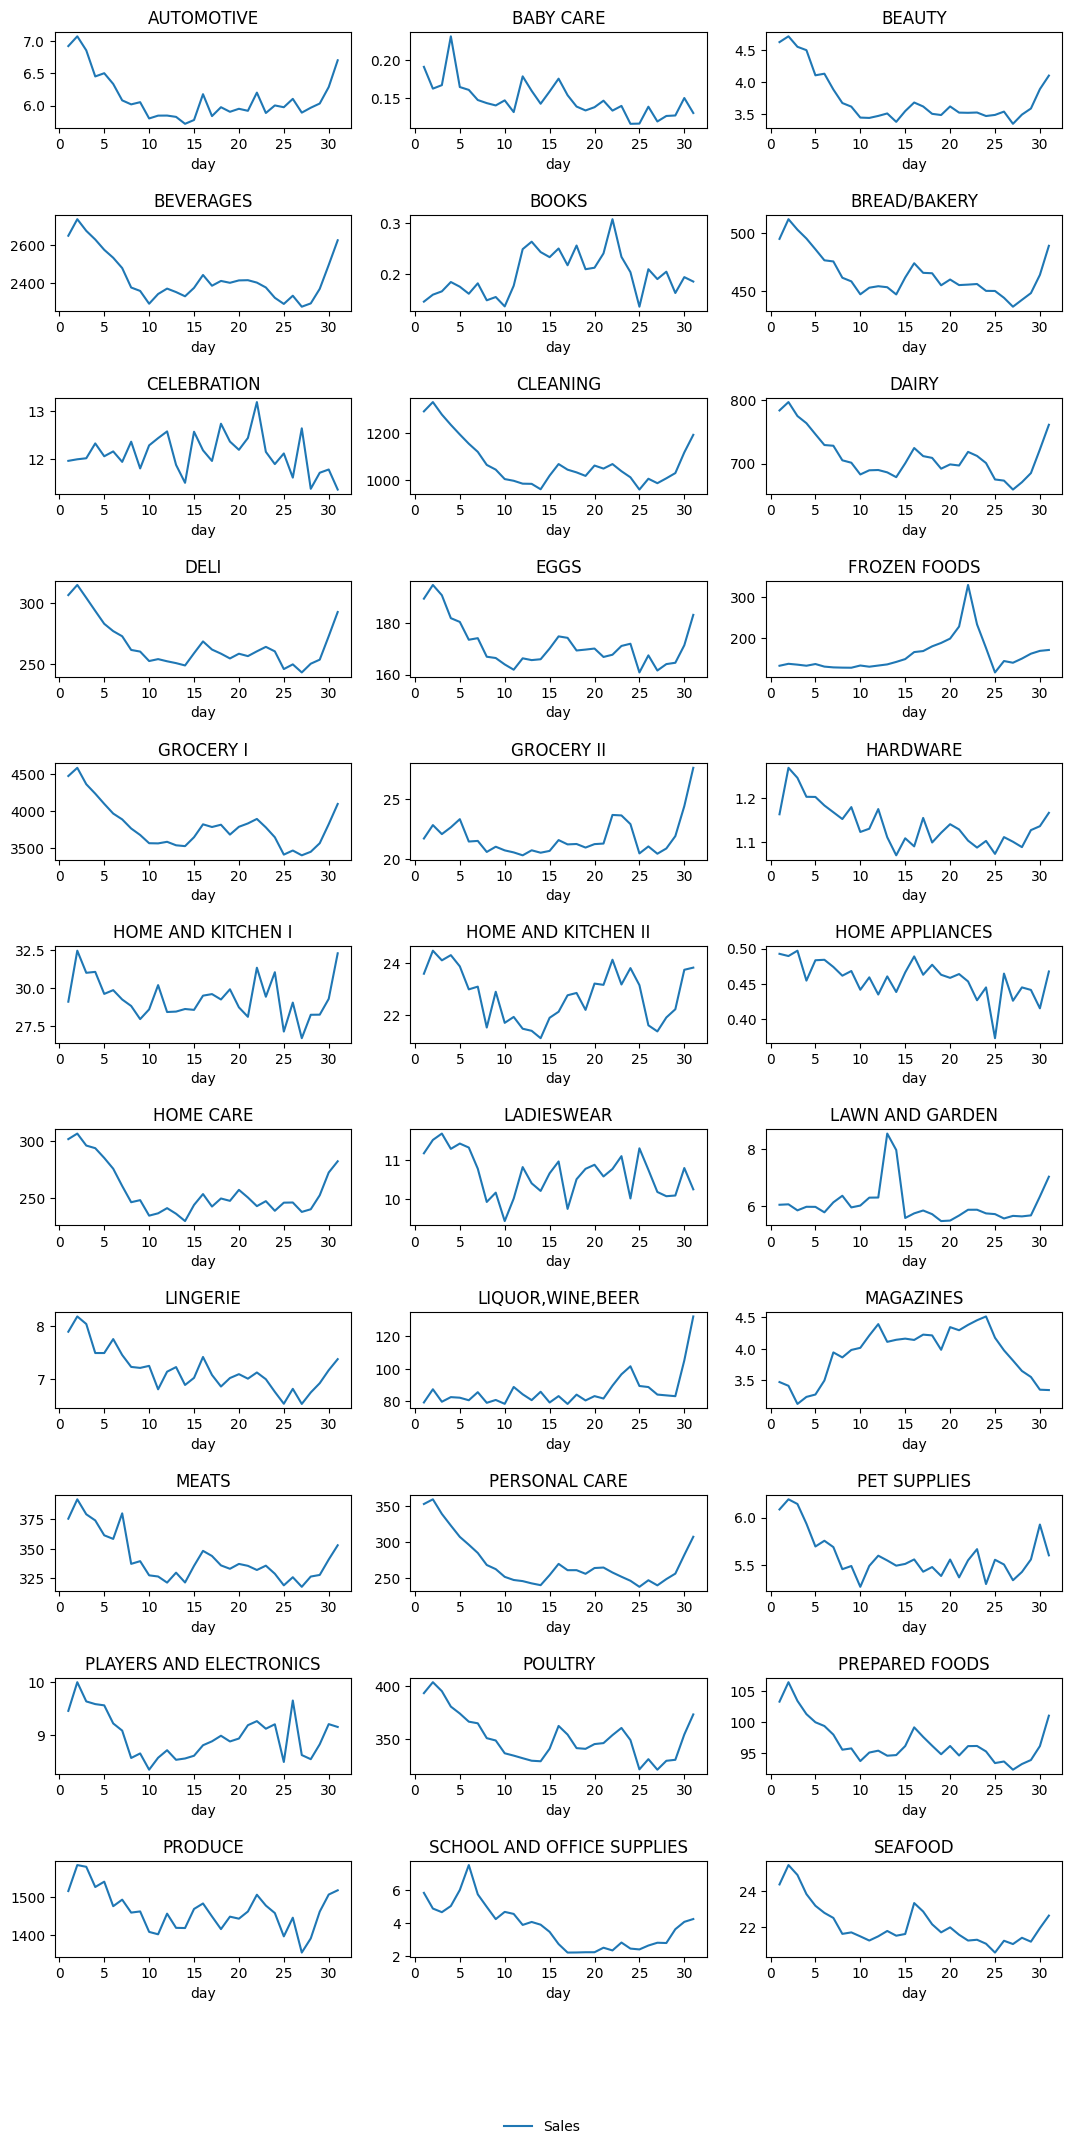

In [59]:
#Which days of the month see the most sales?

# Get unique families and sort them alphabetically
sorted_families = sorted(data_train_filtered['family'].unique())

# Create the plot
fig = plt.figure(figsize=(13, 25))
fig.subplots_adjust(hspace=0.9, wspace=0.2)

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, product in enumerate(sorted_families):
    ax = fig.add_subplot(11, 3, i + 1)
    
    # Plot sales data for the product family
    data_train_filtered.query('family == @product').groupby(['day']).sales.mean().plot(ax=ax, label='Sales')

    plt.title(product)

    # Collect the handles and labels only once (from the first subplot)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, frameon=False)

plt.show()




Most food, beverage, and household items seem to spike at the beginning and end of the month. Ecuadorians get paid either monthly or bi-weekly on the 15th and the last day of the month. Celebration, books, home appliances, home and kitchen I, home and kitchen II, as well as magazines do not follow this trend. Lawn and garden fmily exhibits a spike around the 13th.

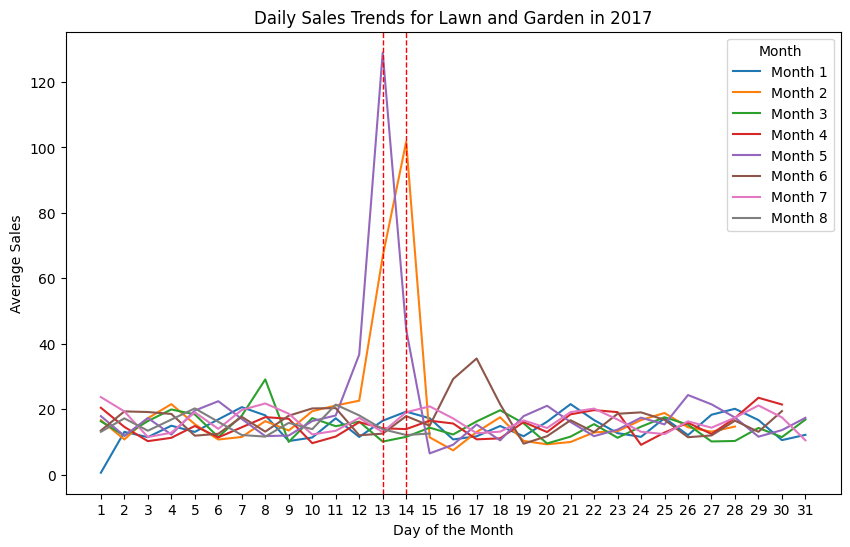

,state,sales_x,sales_y
0,Azuay,108.000000,115.666667
1,Bolivar,0.000000,0.000000
2,Chimborazo,0.000000,0.000000
3,Cotopaxi,0.000000,0.000000
4,El Oro,125.000000,99.500000
5,Esmeraldas,49.000000,15.000000
6,Guayas,109.363636,108.272727
7,Imbabura,0.000000,0.000000
8,Loja,218.000000,67.000000
9,Los Rios,29.000000,40.500000


In [60]:
# Why is there a spike in lawn?

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Filter the data for the specific family and year
select = data_train_filtered.query('family == "LAWN AND GARDEN" and year == 2017')

# Plot sales trends for each month
for month in range(1, 9):  # Train dataset ends in august
    monthly_data = select.query('month == @month')
    monthly_data.groupby(['day']).sales.mean().plot(ax=ax, label=f'Month {month}')

# Set plot title and labels
ax.set_title('Daily Sales Trends for Lawn and Garden in 2017')
ax.set_xlabel('Day of the Month')
ax.set_ylabel('Average Sales')

ax.set_xticks(range(1, 32))  # Set x-axis ticks to cover days 1 to 31
for day in [13, 14]:
    ax.axvline(x=day, color='red', linestyle='--', linewidth=1)
# Add a legend
ax.legend(title='Month')

# Show the plot
plt.show()

# Filter data for the specific date and family
filtered_data = data_train_filtered.query('year == 2017 and month == 2 and day == 14 and family == "LAWN AND GARDEN"')
# Group by state and calculate average sales
grouped_by_state_feb14 = filtered_data.groupby('state')['sales'].mean().reset_index()

# Filter data for the specific date and family
filtered_data = data_train_filtered.query('year == 2017 and month == 5 and day == 13 and family == "LAWN AND GARDEN"')
# Group by state and calculate average sales
grouped_by_state_may13 = filtered_data.groupby('state')['sales'].mean().reset_index()

# Merge the two grouped DataFrames on 'state'
merged_grouped_by_state = pd.merge(grouped_by_state_feb14, grouped_by_state_may13, on='state', how='outer')
display(merged_grouped_by_state )



There are unusual entries in  Lawn and Garden family on the 13th of April and 14th of February of 2017. The sales in this family on any other day do not exceed 40. However, the sales from these days are distributed evenly throughout the stores, and thus are unlikely to be outliers due to human error. In both cases, the states with the high sales volume are the same. They are geographically neighboring to each other, which implies that the high sales could be attributed to some local event.


### Data Cleaning Conculsion <br>
Overall, the data was aleady clean, with no missing values or imbalances. <br>
To see if it makes any difference for model training, I created two versions of the dataset: the first one is unfiltered, it has entries where sales for certain categories are 0 the whole year of 2013 and there are several months with 0 sales for certain item categories in 2014. <br>
In the second, filtered, dataset 2013 entries with 0 sales the whole year were removed and the 0 sales months in 2014 wrere imputed by taking the mean of the other months that year.

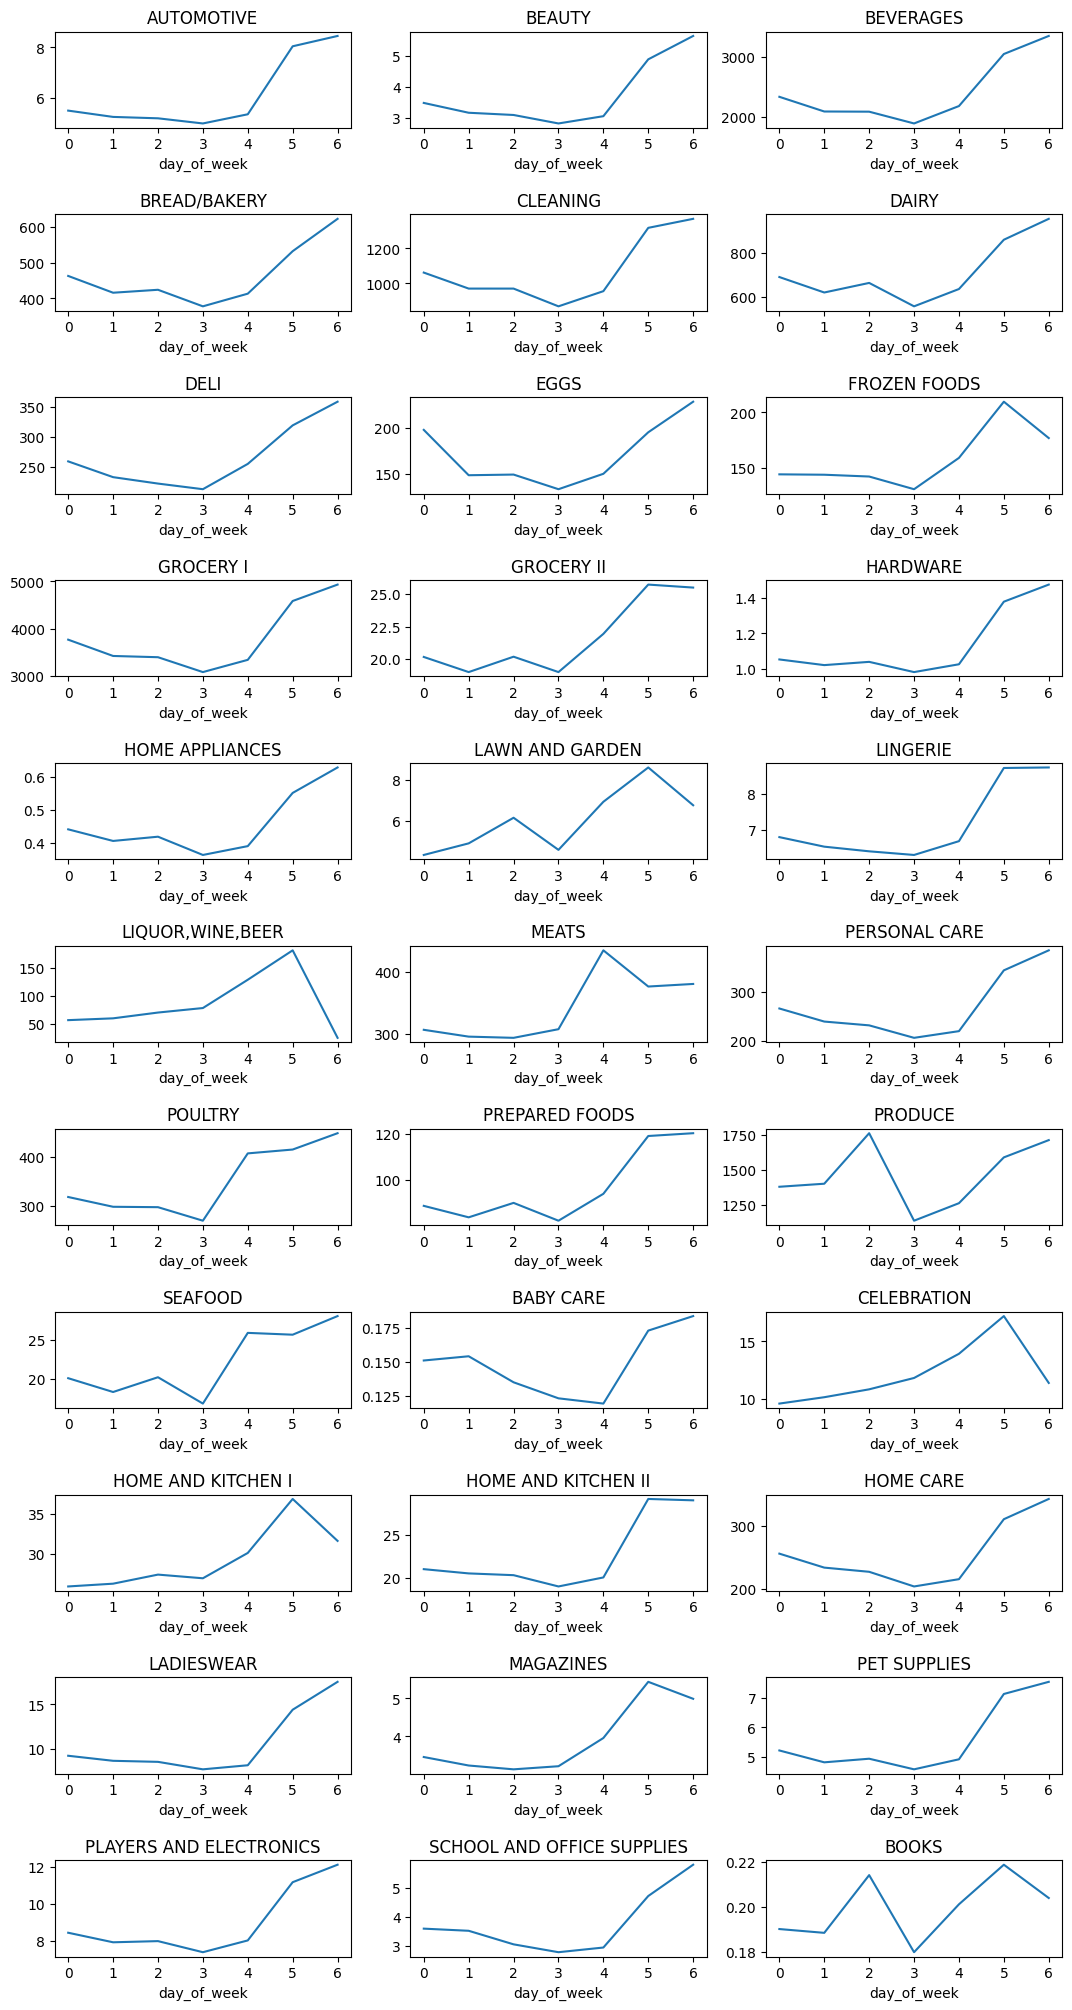

In [61]:
# Which days of the week see spikes in sales?

fig = plt.figure(figsize=(13, 25))
fig.subplots_adjust(hspace=0.9, wspace=0.2)

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, product in enumerate(data_train_filtered.family.unique()):
    ax = fig.add_subplot(11, 3, i + 1)
    data_train_filtered.query('family==@product').groupby(['day_of_week']).sales.mean().plot(ax=ax,label=year)

    plt.title(product)
plt.show()



Most shopping tends to happen on Saturdays (5) and Sundays (6), with the excpetion of alcohol, the sale of which used to be prohibited on Sundays.

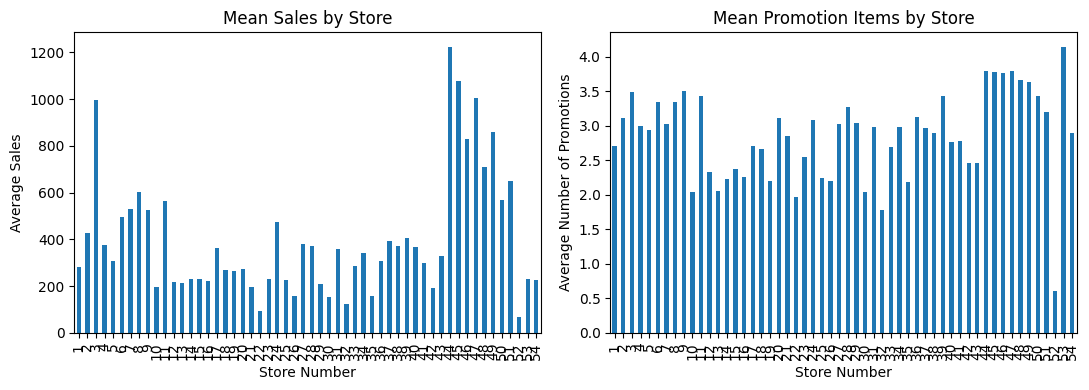

In [62]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize = (11,4))

# Sales ranking by store
data_train_filtered.groupby('store_nbr').sales.mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Mean Sales by Store')
axs[0].set_xlabel('Store Number')
axs[0].set_ylabel('Average Sales')

# Promotion items ranking by store
data_train_filtered.groupby('store_nbr').onpromotion.mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Mean Promotion Items by Store')
axs[1].set_xlabel('Store Number')
axs[1].set_ylabel('Average Number of Promotions')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


From the graph above, it is evident that there is some correlation between store sales and number of items on promotion. For example, stores #44-51 have a high volume of sales accompanied by a large number of items on promotion. On the othetr hand, store #52 has both low number of discounte ditems and low sales.

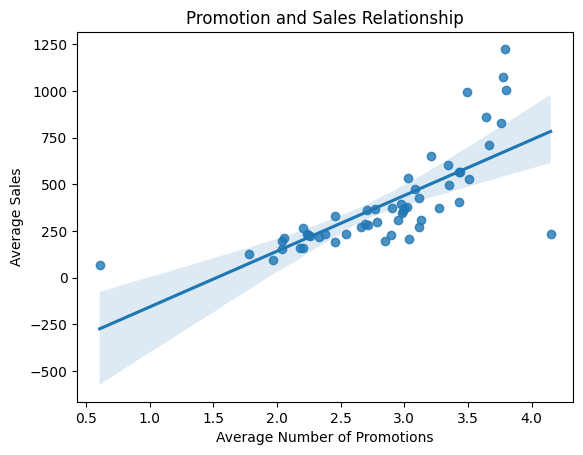

The correlation coefficient is 0.4227501340057197 , which indicates that there  is moderate positive correlation between sales and number of promotion items


In [63]:
# What is the correlation between Sales and Promotions
# Group by 'store_nbr' and calculate the mean for 'onpromotion' and 'sales'
grouped_data = data_train_filtered.groupby('store_nbr')[['onpromotion', 'sales']].mean()

# Plot the scatter plot with a trend line using Seaborn's regplot
plt.figure()
sns.regplot(x='onpromotion', y='sales', data=grouped_data)

plt.title('Promotion and Sales Relationship')
plt.xlabel('Average Number of Promotions')
plt.ylabel('Average Sales')
plt.show()

# Calculate the correlation between 'sales' and 'onpromotion'
correlation = data_train_filtered[['sales', 'onpromotion']].corr()

# Display the correlation matrix
print("The correlation coefficient is", correlation.loc['sales', 'onpromotion'] , ", which indicates that there  is moderate positive correlation between sales and number of promotion items")


The moderate positive correlation between the average number of promotions and the average sales figure indicates that on average, for each additional promotional item that a store has, it's sales increase by roughly 300. 

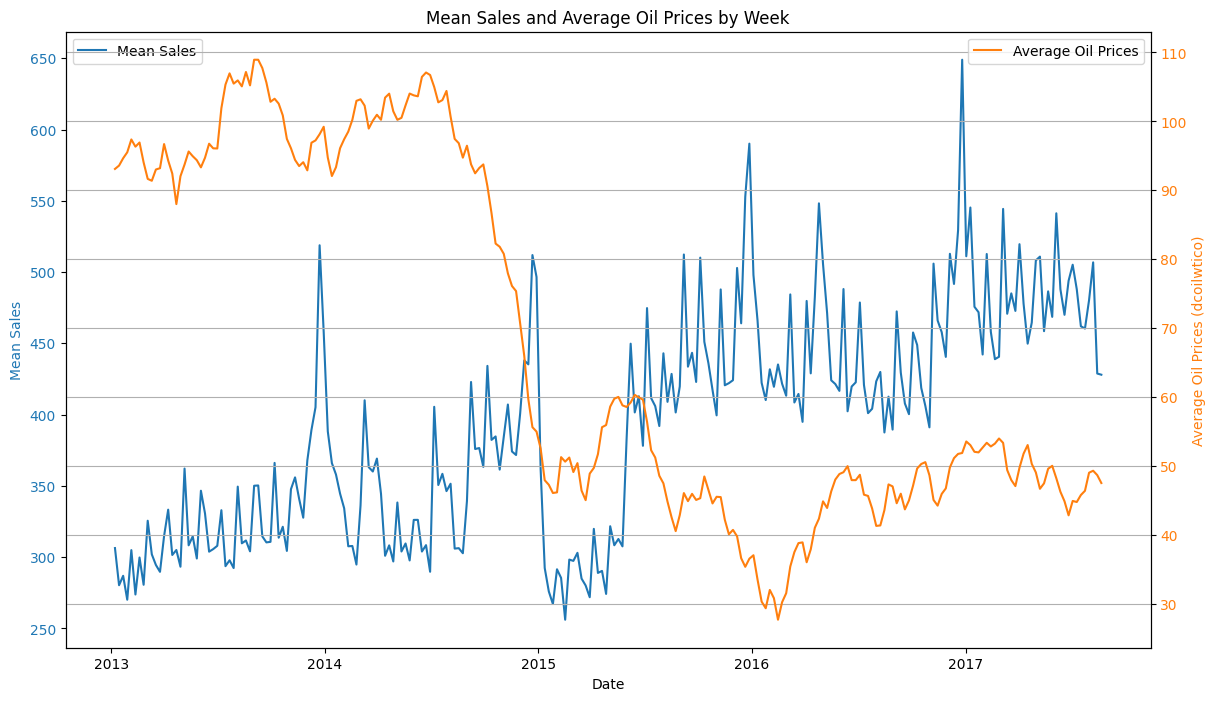

In [64]:
#How do oil prices correlate with sales?
# Ensure 'date' is a datetime type
data_train_filtered['date'] = pd.to_datetime(data_train_filtered['date'])

# Aggregate data by week
weekly_aggregated_data = data_train_filtered.resample('W-Mon', on='date').agg(
    mean_sales=('sales', 'mean'),
    avg_oil_prices=('dcoilwtico', 'mean')
).reset_index()

# Create a figure and a set of subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot mean sales on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean Sales', color=color)
ax1.plot(weekly_aggregated_data['date'], weekly_aggregated_data['mean_sales'], color=color, label='Mean Sales')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for oil prices
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Average Oil Prices (dcoilwtico)', color=color)
ax2.plot(weekly_aggregated_data['date'], weekly_aggregated_data['avg_oil_prices'], color=color, label='Average Oil Prices')
ax2.tick_params(axis='y', labelcolor=color)

# Add titles and legends
plt.title('Mean Sales and Average Oil Prices by Week')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.grid(True)
plt.show()


The figure above graphs the mean sales and oil prices over the years. Noticeably, the overall trend for the sales is positive, meaning it increase from year to year, while the oil prices decrease with a large drop around mid 2014. Despite the overall trends moving in opposite direction for these variables, during the oil price drop in 2014 and its subsequent recovery in 2015, the mean sales dwindled during that period.

### Data Visualization Summary <br>
Overall, there is strong evidence of correlation between sales and oil prices, promotions, days of the week, month, months of the year, as evidenced by the graphs in this section.

In [65]:
#Which products do people stop buying when th eprice of oil goes up?

# Aggregate data by date and family
aggregated_data = data_train_filtered.groupby(['family', 'date']).agg(
    mean_sales=('sales', 'mean'),
    avg_oil_prices=('dcoilwtico', 'mean')
).reset_index()

# Compute correlation for each family
correlations = {}
for family in aggregated_data['family'].unique():
    family_data = aggregated_data[aggregated_data['family'] == family]
    correlation = family_data[['mean_sales', 'avg_oil_prices']].corr().iloc[0, 1]
    correlations[family] = correlation

# Convert to DataFrame
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Family', 'Correlation'])

# Add a column for absolute correlation values
correlation_df['Absolute Correlation'] = correlation_df['Correlation'].abs()

# Sort by absolute correlation values in descending order
sorted_correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)

# Drop the Absolute Correlation column for final output
sorted_correlation_df = sorted_correlation_df.drop(columns='Absolute Correlation')

# Print sorted correlations
pd.set_option('display.max_rows', None)

display(sorted_correlation_df)
pd.reset_option('display.max_rows')


,Family,Correlation
5,BREAD/BAKERY,-0.741960
8,DAIRY,-0.693030
3,BEVERAGES,-0.684170
9,DELI,-0.679218
16,HOME AND KITCHEN II,-0.645196
2,BEAUTY,-0.629679
0,AUTOMOTIVE,-0.606986
29,PREPARED FOODS,-0.595517
25,PERSONAL CARE,-0.582250
12,GROCERY I,-0.580308


The table above shows the correlation between oil prices and mean sales across all stores, sorted by their absolute value. The sales of item families on the top of the list show a strong negative correlation with oil price. This means that when the oil prices increase, the  Sales of all item families go down as the price of oil rises, except for lingerie, books, ladieswear the sales of which go up. Home appliances, home care items as weel as players and electronics are bought at roughly the same rate, regardless of oil price. 

### Model Building and Training

In [66]:
#Build model with the filtered data 

features = ['id', 'store_nbr', 'family', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'day_name', 'dcoilwtico', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'city', 'state',
       'store_type', 'cluster', 'transactions']

# Encode categorical features using get_dummies
data_train_encoded = pd.get_dummies(data_train_filtered[features], drop_first=True)


target = 'sales'
X = data_train_encoded
y = data_train_filtered[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [67]:
# Build model with unfiltered data

features = ['id', 'store_nbr', 'family', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'day_name', 'dcoilwtico', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'city', 'state',
       'store_type', 'cluster', 'transactions']

data_train_encoded = pd.get_dummies(data1[features], drop_first=True)


target = 'sales'
X = data_train_encoded
y = data1[target]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model2 = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

xgb_model2.fit(X_train2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Results

In [68]:
#Make predictions on the filtered test set 
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 76965.60
Root Mean Squared Error: 277.43
Mean Absolute Error: 83.17
R^2 Score: 0.94


Above are the results for the filtered model, removing the prolonged  and recurring 0 sales entries. This is a highly predictive model, expalining 94% of the variability in sales. I provided 4 diffrent metrics to estimate this reagression.

In [69]:
# Make predictions on the unfiltered test set 2
y_pred2 = xgb_model2.predict(X_test2)


mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)
mae2 = mean_absolute_error(y_test2, y_pred2)
rmse2 = root_mean_squared_error(y_test2, y_pred2)
print(f"Mean Squared Error: {mse2:.2f}")
print(f"Root Mean Squared Error: {rmse2:.2f}")
print(f"Mean Absolute Error: {mae2:.2f}")
print(f"R^2 Score: {r22:.2f}")

Mean Squared Error: 69062.80
Root Mean Squared Error: 262.80
Mean Absolute Error: 79.30
R^2 Score: 0.95


Above are the results of teh unfiltered model. The **Mean Squared Error (MSE)** of 69062.80 measures the average squared differences between predicted and actual values, penalizing larger errors. **Root Mean Squared Error (RMSE)** of 262.80 gives an interpretable error magnitude in the original units. **Mean Absolute Error (MAE)** of 79.30 reflects the average magnitude of errors without considering direction. The **R² Score** of 0.95 indicates that 95% of the variance in sales is explained by the model. These metrics provide distinct perspectives on model performance. <br>
As you can see, this model performs even better than the filtered one.

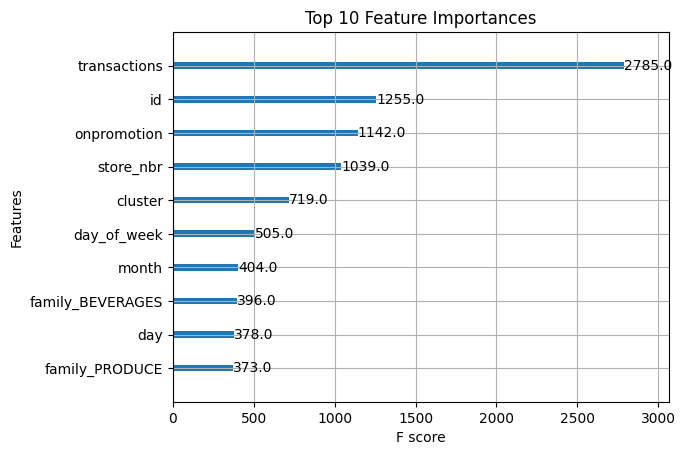

In [70]:
# Plot Feature Importance
xgb.plot_importance(xgb_model2, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()


From the graph above, it is evident that teh volume of transactions was by far the most important predictor of sales. 

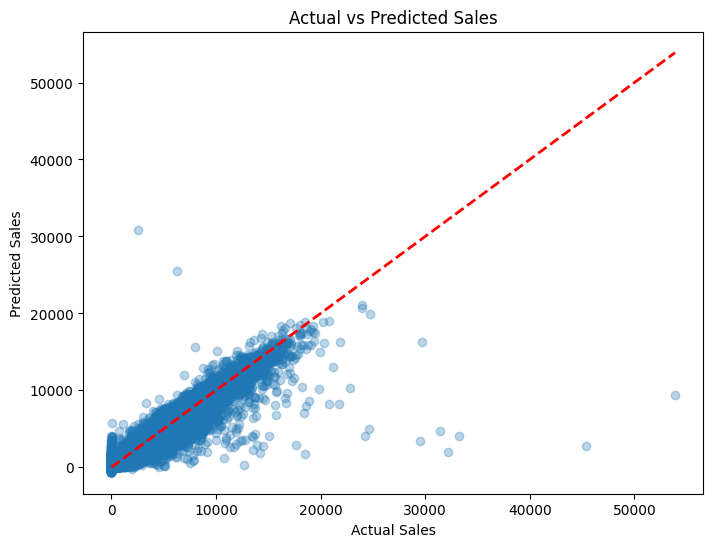

In [71]:
# Plot Actual vs. Predicted Sales
plt.figure(figsize=(8, 6))
plt.scatter(y_test2, y_pred2, alpha=0.3)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()


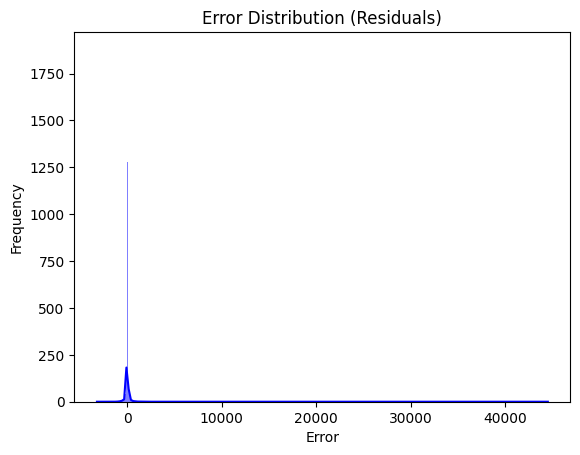

In [72]:
# Randomly sample a smaller portion of the errors for faster plotting
sampled_errors = errors.sample(frac=0.1, random_state=42)

sns.histplot(sampled_errors, kde=True, color='blue')
plt.title('Error Distribution (Residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


This model was not covered in class, but it is a supervised learnning algorithm based on decision trees and gradient boosting. For this model, I employed feature engineering by splitting the date data into several columns and one hot encdoing the categorical values. I also tuned the hyperparameters, manually setting the number of estimators and leraning rate. <br>
<br>
To solve this regression task (predicting continuous values), I trained a XGBoost model. The two iterations of this model use filtered and unfiltered data to predict sales. First, categorical features are encoded using one-hot encoding, which converts them into binary columns. The dataset is split into training and testing sets, with 80% used for training and 20% for testing. The model chosen is an XGBoost regressor (`XGBRegressor`) with 200 estimators, a learning rate of 0.1, and a maximum depth of 6. XGBoost is based on gradient boosting of decision trees to optimize performance, making it a good pick for large datasets such as this one.The model is trained on the training data  to predict the target variable, `sales`.The model achieves very high predictive power with both filtered and unfiltered datasets. In fact, the R-squared value is 0.01 higher for the unfiltered dataset, and the MSE is 11% lower. 

### Conclusion
<br>
In this project, I combined data from 5 separate datasets to forecast the sales for a large supermarket chain. After performing a detailed exploratory analysis, I used features such as oil price, holiday schedule, location, as well as past sales and transactions history to train a supervised machine learning algorithm, XGboost to predict the upcoming sales. The algorithm achieved very high hpredictive power of 0.95, which means that 95% of variability in sales can be explained by this regression model.<br>
This project highlights the importance of data preprocessing, handling missing or erroneous data, and optimizing model performance through hyperparameter tuning. Key takeaways include understanding how different evaluation metrics reveal model accuracy and error patterns, and how iterative training and analysis improve predictive outcomes in real-world datasets.<br>
Deleting rows with 0 sales and imputing data didn't improve the model because these zero sales might hold meaningful patterns or signals related to seasonal trends, store closures, or stockouts. Removing or imputing them may have introduced noise or bias, distorting relationships in the data and reducing prediction accuracy.<br>
Overall, this project was successful in its goal, and can be further improved. To further improve the model, one could tune hyperparameters with techniques like Grid Search or Randomized Search. Incorporate feature engineering to capture more relevant information. Use cross-validation for robust evaluation and explore advanced models or ensemble methods. Address any data quality issues and ensure feature scaling for better performance.